In [17]:
from utils import get_puzzle_input_as_rows
import re
from enum import Enum
from typing import Iterable

In [18]:
INPUT_REGEX = re.compile(r"Sensor at x=(-?\d+), y=(-?\d+): closest beacon is at x=(-?\d+), y=(-?\d+)")

Coordinate = tuple[int, int]

TUNING_VALUE = 4000000

class PointState(str, Enum):
    """ used for printing """
    beacon = 'B'
    sensor = 'S'
    no_beacon = '#'
    unknown = '.'

def parse_input(is_test: bool) -> Iterable[tuple[Coordinate, Coordinate]]:
    for row in get_puzzle_input_as_rows(2022, 15, test=is_test):
        if match := INPUT_REGEX.match(row):
            sensor = int(match.group(1)), int(match.group(2))
            closest_beacon = int(match.group(3)), int(match.group(4))
            yield sensor, closest_beacon
        else:
            raise ValueError("bad input data")

def get_manhattan_distance(point_a: Coordinate, point_b: Coordinate) -> int:
    a_x, a_y = point_a
    b_x, b_y = point_b
    return abs(a_x - b_x) + abs(a_y - b_y)

def get_sensor_diamond_points(distance_to_edge: int, sensor: Coordinate):
    """ gets the 4 corner points of the sensor diamond that is formed when it detects the closest beacon """
    def _inner():
        sensor_x, sensor_y = sensor
        yield sensor_x - distance_to_edge, sensor_y
        yield sensor_x, sensor_y + distance_to_edge
        yield sensor_x + distance_to_edge, sensor_y
        yield sensor_x, sensor_y - distance_to_edge
    return list(_inner())

def get_x_anchors(distance_to_edge: int, y: int, sensor: Coordinate):
    """ gets the furthest left and right x values of the sensor diamond at level y """
    sensor_x, sensor_y = sensor
    anchor_a = sensor_x - distance_to_edge + abs(sensor_y - y)
    anchor_b = distance_to_edge - abs(sensor_y - y) + sensor_x
    if anchor_a > anchor_b:
        anchor_b, anchor_a = anchor_a, anchor_b
    if get_manhattan_distance(sensor, (anchor_a, y)) == distance_to_edge:
        return anchor_a, anchor_b
    else:
        return None

In [32]:
def question_15_a(is_test: bool):
    sensors = set()
    beacons = set()
    positions = []
    for sensor, closest_beacon in parse_input(is_test=is_test):
        distance = get_manhattan_distance(sensor, closest_beacon)
        positions.append((sensor, closest_beacon, distance))
        sensors.add(sensor)
        beacons.add(closest_beacon)

    Y = 10 if is_test else 2000000
    
    no_beacons = set()
    for sensor, closest_beacon, closest_beacon_distance in positions:
        # print("sensor", sensor)
        if (anchors := get_x_anchors(closest_beacon_distance, Y, sensor)) is not None:
            anchor_a, anchor_b = anchors
            # print("sensor", sensor, f"X anchors at y={y}", anchor_a, anchor_b)
            for x in range(anchor_a, anchor_b + 1):
                point = (x, Y)
                if point not in sensors and point not in beacons:
                    no_beacons.add(point)
    print(len(no_beacons))

    # visualisation
    if is_test:

        # the min and max x values a beacon could not possibly exist at are the x values
        # of the sensor +/- the manhattan distance to the closest beacon
        # any x values lower or higher than this will always be state unknown so we don't need to draw them
        min_x = min([sensor_x - distance for (sensor_x, _), _, distance in positions])
        max_x = max([sensor_x + distance for (sensor_x, _), _, distance in positions])
        min_y = min([sensor_y - distance for (_, sensor_y), _, distance in positions])
        max_y = max([sensor_y + distance for (_, sensor_y), _, distance in positions])

        for y in range(min_y, max_y + 1):
            chars = []
            for x in range(min_x, max_x + 1):
                point = (x, y)
                if point in beacons:
                    point_state = PointState.beacon
                elif point in sensors:
                    point_state = PointState.sensor
                elif point in no_beacons:
                    point_state = PointState.no_beacon
                else:
                    point_state = PointState.unknown

                chars.append(point_state.value)
            print(" ".join(chars))

# takes around 11 seconds - far too slow to use in the next part
question_15_a(is_test=False)  # 5166077
    

5166077


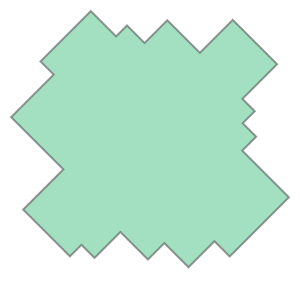

tuning_freq 13071206703981


In [28]:
from shapely.geometry import Polygon
from shapely.ops import unary_union

def question_15_b(is_test: bool):

    # turns out this is not needed using this approach
    MAX_X = 20 if is_test else 4000000
    
    polygons = []
    for sensor, closest_beacon in parse_input(is_test=is_test):
        distance = get_manhattan_distance(sensor, closest_beacon)
        points = get_sensor_diamond_points(distance, sensor)
        polygons.append(Polygon(points))

    polygon = unary_union(polygons)

    display(polygon)

    for i in polygon.interiors:
        p = Polygon(i.coords[:])
        center = p.centroid

        # this handles where two polygons are directly next to each other but still get 
        # seen as distinct shapes in the union (probably due to floating point issues)
        if (x := center.x).is_integer() and (y := center.y).is_integer():
            tuning_freq = int((x * TUNING_VALUE) + y)
            print("tuning_freq", tuning_freq)

question_15_b(is_test=False)